**Importing Libaries**

In [1]:
# Thư viện trực quan hóa và xử lý dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set()

# Thư viện xử lý ngôn ngữ
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Thư viện xử lý file
import zipfile
from wordcloud import WordCloud
from collections import Counter
from IPython.display import display

# Thư viện học máy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Importing DataSet**

In [2]:
# Giải nén, đọc và hiển thị dữ liệu
with zipfile.ZipFile('Data/True.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')

with zipfile.ZipFile('Data/Fake.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')

Fake = pd.read_csv("Data/Fake.csv")
Real= pd.read_csv("Data/True.csv")

print(f"Fake.csv: {Fake.shape}")
display(Fake.head())

print(f"\nReal.csv: {Real.shape}")
display(Real.head())

Fake.csv: (23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"



Real.csv: (21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


**Inserting a column "class" as target feature**

In [3]:
# Gán nhãn 0 cho tin giả. 1 cho tin thật
Fake["label"] = 0
Real["label"] = 1

**Merging 2 dataframes**

In [4]:
# Ghép hai dataframe
data = pd.concat([Fake, Real], ignore_index=True)

# Loại bỏ các cột không cần thiết (nếu tồn tại)
data = data.drop(columns=[col for col in ["title", "subject", "date"] if col in data.columns], errors='ignore')

data.sample(5)

,text,label
43154,SAO PAULO (Reuters) - Approval for Brazilian P...,1
34509,"DES MOINES, Iowa (Reuters) - If Hillary Clinto...",1
20992,"Only months ago, Obama s Attorney General, Lor...",0
41418,ANKARA (Reuters) - Turkey urged the United Sta...,1
9200,How did the FBI handle the Clinton email case ...,0


**Cleaning data**

In [5]:
# Kiểm tra dữ liệu thiếu
data.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Xóa links khỏi văn bản
    text = re.sub(r'(http[s]?://\S+|www\.\S+|\S+\.(com|net|org))', '', text)

    # Chuyển chữ hoa thành chữ thường
    text = text.lower()

    # Loại bỏ ký tự đặc biệt và các khoảng trắng thừa
    text = re.sub(r'[^a-zA-Z\s]', '', text).strip()
    text = re.sub(r'\s+', ' ', text)

    # Lemmatization và loại bỏ từ dừng
    text = ' '.join(lemmatizer.lemmatize(word, pos='v') for word in text.split() if word not in stop_words)
    return text

data['text'] = data['text'].apply(clean_text)

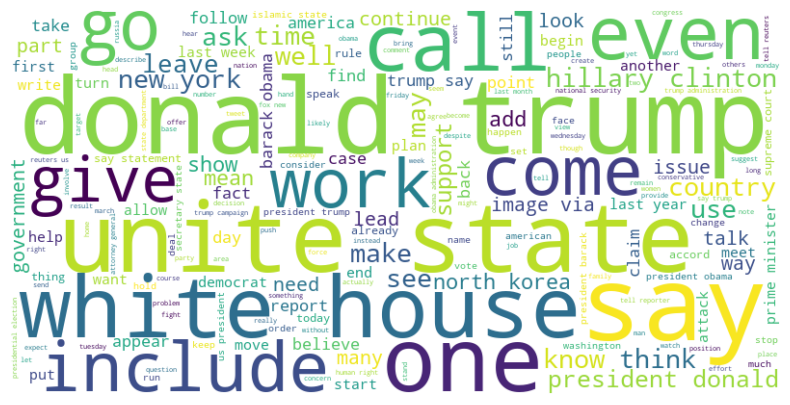

In [7]:
# Trực quan hóa dữ liệu
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(data.text))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Splitting training and testing** 

In [8]:
X = data["text"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, shuffle =True)

**Vectorization**

In [9]:
# Vectorization sử dụng TF-IDF
vectorizer = TfidfVectorizer()
XV_train = vectorizer.fit_transform(X_train)
XV_test = vectorizer.transform(X_test)

**Classification using different model**

In [10]:
# Khởi tạo các mô hình
nb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=100, random_state=24, n_jobs=-1)
lgr = LogisticRegression(random_state=24)
sgd = SGDClassifier(loss='hinge', random_state=24, max_iter=1000, tol=1e-3)

# Huấn luyện các mô hình
nb.fit(XV_train, y_train)
rf.fit(XV_train, y_train)
lgr.fit(XV_train, y_train)
sgd.fit(XV_train, y_train)

# Dự đoán
y_pred_nb = nb.predict(XV_test)
y_pred_rf = rf.predict(XV_test)
y_pred_lgr = lgr.predict(XV_test)
y_pred_sgd = sgd.predict(XV_test)

# Hàm đánh giá mô hình
def evaluate_model(y_test, y_pred, model_name):
    print(f"Evaluted the model {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")

# Đánh giá từng mô hình
evaluate_model(y_test, y_pred_nb, "Multinomial Naive Bayes")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_lgr, "Logistic Regression")
evaluate_model(y_test, y_pred_sgd, "SGD Classifier")

Evaluted the model Multinomial Naive Bayes
Accuracy: 0.9398663697104677
Precision: 0.924948358962589
Recall: 0.9497996700447796
F1 Score: 0.9372093023255814
Confusion Matrix:
 [[4410  327]
 [ 213 4030]]


Evaluted the model Random Forest
Accuracy: 0.9914253897550112
Precision: 0.9903483992467044
Recall: 0.9915154371906669
F1 Score: 0.9909315746084089
Confusion Matrix:
 [[4696   41]
 [  36 4207]]


Evaluted the model Logistic Regression
Accuracy: 0.9875278396436525
Precision: 0.9833840393166393
Recall: 0.9903370256893708
F1 Score: 0.9868482855800845
Confusion Matrix:
 [[4666   71]
 [  41 4202]]


Evaluted the model SGD Classifier
Accuracy: 0.9913140311804008
Precision: 0.9875907281667057
Recall: 0.9941079424935187
F1 Score: 0.9908386187455955
Confusion Matrix:
 [[4684   53]
 [  25 4218]]




**Model Testing**

In [11]:
def output_label(n):
    labels = {0: "Fake New", 1: "Not A Fake New"}
    return labels.get(n, "Unknown Label")

def manual_testing(news):
    if not news:
        return "Please enter a text to check!"

    # Chuẩn bị dữ liệu đầu vào
    testing_news = {"text": [news]}
    new_df_test = pd.DataFrame(testing_news)
    new_df_test["text"] = new_df_test["text"].apply(clean_text)

    # Vectorize dữ liệu
    new_XV_test = vectorizer.transform(new_df_test["text"])

    # Dự đoán với các mô hình
    pred_nb = nb.predict(new_XV_test)
    pred_rf = rf.predict(new_XV_test)
    pred_lgr = lgr.predict(new_XV_test)
    pred_sgd = sgd.predict(new_XV_test)

    predictions = {
        "Naive Bayes": output_label(pred_nb[0]),
        "Random Forest": output_label(pred_rf[0]),
        "Logistic Regression": output_label(pred_lgr[0]),
        "SGD": output_label(pred_sgd[0])
    }

    results_df = pd.DataFrame(list(predictions.items()), columns=["Model", "Result"])
    print("\nPredictions from models:")
    display(results_df)

In [12]:
# Nhập input từ bàn phím
print("===== Fake News Detection System =====\n")
news = str(input())
print(f"Text: {news}")
manual_testing(news)

===== Fake News Detection System =====

Text: SAO PAULO (Reuters) - Cesar Mata Pires, the owner and co-founder of Brazilian engineering conglomerate OAS SA, one of the largest companies involved in Brazil s corruption scandal, died on Tuesday. He was 68. Mata Pires died of a heart attack while taking a morning walk in an upscale district of S o Paulo, where OAS is based, a person with direct knowledge of the matter said. Efforts to contact his family were unsuccessful. OAS declined to comment. The son of a wealthy cattle rancher in the northeastern state of Bahia, Mata Pires  links to politicians were central to the expansion of OAS, which became Brazil s No. 4 builder earlier this decade, people familiar with his career told Reuters last year. His big break came when he befriended Antonio Carlos Magalh es, a popular politician who was Bahia governor several times, and eventually married his daughter Tereza. Brazilians joked that OAS stood for  Obras Arranjadas pelo Sogro  - or  Work A

,Model,Result
0,Naive Bayes,Not A Fake New
1,Random Forest,Not A Fake New
2,Logistic Regression,Not A Fake New
3,SGD,Not A Fake New


In [13]:
print("===== Fake News Detection System =====\n")
news = str(input())
print(f"Text: {news}")
manual_testing(news)

===== Fake News Detection System =====

Text: Trump’s border wall: Trump repeated his false claim that “I built over 500 miles of wall” on the southern border. Official government data shows 458 miles were built under Trump – including both wall built where no barriers had existed before and wall built to replace previous barriers.  Trump’s crowds: Trump falsely claimed of his rallies: “We never have an empty seat.” There have been empty seats at numerous Trump rallies over the years – including hundreds at this very rally in Reading. And at many Trump rallies, some once-filled seats empty out during his speeches when supporters leave.  Trump’s crowd in Butler: Trump falsely claimed there were “over 100,000 people” at the rally he held Saturday in Butler, Pennsylvania, at the same site where a gunman had attempted to assassinate him in July. CNN affiliate KDKA in Pittsburgh reported that the Secret Service put the crowd at 24,000 people, while the Trump-supporting sheriff of Blair Coun

,Model,Result
0,Naive Bayes,Fake New
1,Random Forest,Fake New
2,Logistic Regression,Fake New
3,SGD,Fake New
